In [1]:
#!/usr/bin/python
import talib
import requests
import python_bitbankcc
import pandas as pd
import numpy as np
from datetime import datetime,date, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter

In [2]:
API = python_bitbankcc.public()
l = ['2015', '2016', '2017', '2018', '2019', '2020']
pair = 'btc_jpy'
period = '1day'
ohlcv = []
for year in l:
    ohlcv.extend(API.get_candlestick(pair, period, year)['candlestick'][0]['ohlcv'])
df = pd.DataFrame(ohlcv, columns = ['Open', 'High', 'Low', 'Close', 'Volume', 'Time'])
df['Time'] = [datetime.fromtimestamp(float(time)/1000) for time in df['Time']]
df.drop('Volume', axis=1, inplace=True)
df.set_index('Time',inplace=True)
df.tail()

,Open,High,Low,Close
Time,,,,
2020-07-26,1028222,1059999,1022001,1051976
2020-07-27,1051976,1198000,1051137,1159601
2020-07-28,1159871,1180000,1112011,1146688
2020-07-29,1146545,1190000,1140001,1167600
2020-07-30,1167600,1170695,1150900,1154801


In [3]:
df['Open'] = df['Open'].astype(np.int64)
df['High'] = df['High'].astype(np.int64)
df['Low'] = df['Low'].astype(np.int64)
df['Close'] = df['Close'].astype(np.int64)

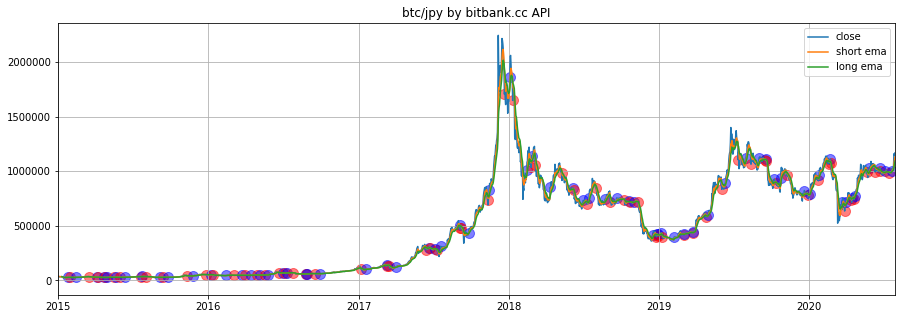

In [4]:
def EMA_TaLib(df, p1, p2):
    df1 = df.copy()
    df1["ema1"] = talib.EMA(df1['Close'], timeperiod=p1)
    df1["ema2"] = talib.EMA(df1['Close'], timeperiod=p2)
    df1["diff"] = df1.ema1 - df1.ema2

    # Exponential Moving Average and scatter plot for golden and dead cross signals
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1, 1, 1)
    ax.set_title('btc/jpy by bitbank.cc API')
    ax.plot(df1.index, df1.Close, label="close")
    ax.plot(df1.index, df1.ema1, label="short ema")
    ax.plot(df1.index, df1.ema2, label="long ema")
    ax.set_xlim(df1.index[0], df1.index[-1])
    locator = mdates.AutoDateLocator()
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(mdates.AutoDateFormatter(locator))
    ax.xaxis.set_major_formatter(DateFormatter('%Y'))
    ax.grid()

    # Cross points
    for i in range(1, len(df1)):
        if df1.iloc[i-1]["diff"] < 0 and df1.iloc[i]["diff"] > 0:
            # print("{}:GOLDEN CROSS".format(df1.index[i]))
            ax.scatter(df1.index[i], df1.iloc[i]["Close"], marker="o", s=100, color="b", alpha=0.5)

        if df1.iloc[i-1]["diff"] > 0 and df1.iloc[i]["diff"] < 0:
            # print("{}:DEAD CROSS".format(df1.index[i]))
            ax.scatter(df1.index[i], df1.iloc[i]["Close"], marker="o", s=100, color="r", alpha=0.5)
    ax.legend()

EMA_TaLib(df, 5, 10)

In [5]:
from backtesting import Strategy
from backtesting.lib import crossover

def EMA_Backtesting(values, n):
    """
    Return exponential moving average of `values`, at
    each step taking into account `n` previous values.
    """
    close = pd.Series(values)
    return talib.EMA(close, timeperiod=n)

class EmaCrossStrategy(Strategy):
    
    # Define the two EMA lags as *class variables*
    # for later optimization
    n1 = 5
    n2 = 10
    
    def init(self):
        # Precompute two moving averages
        self.ema1 = self.I(EMA_Backtesting, self.data.Close, self.n1)
        self.ema2 = self.I(EMA_Backtesting, self.data.Close, self.n2)
    
    def next(self):       
        # If ema1 crosses above ema2, buy the asset
        if crossover(self.ema1, self.ema2):
            self.position.close()
            self.buy()

        # Else, if ema1 crosses below ema2, sell it
        elif crossover(self.ema2, self.ema1):
            self.position.close()
            self.sell()

/opt/conda/lib/python3.7/site-packages/backtesting/_plotting.py:44: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

In [6]:
from backtesting import Backtest
# start from 1 BTC with the commission 0.12%

df_ = df.copy()
bt_ema = Backtest(df_, EmaCrossStrategy, cash=1, commission=.0012, trade_on_close=True)
bt_ema.run()

Start                     2015-01-01 00:00:00
End                       2020-07-30 00:00:00
Duration                   2037 days 00:00:00
Exposure [%]                          98.4291
Equity Final [$]                      83.5116
Equity Peak [$]                        108.37
Return [%]                            8251.16
Buy & Hold Return [%]                 2969.48
Max. Drawdown [%]                    -43.0488
Avg. Drawdown [%]                    -10.8991
Max. Drawdown Duration      256 days 00:00:00
Avg. Drawdown Duration       31 days 00:00:00
# Trades                                  134
Win Rate [%]                          35.8209
Best Trade [%]                        129.537
Worst Trade [%]                      -14.2521
Avg. Trade [%]                        4.69578
Max. Trade Duration          99 days 00:00:00
Avg. Trade Duration          15 days 00:00:00
Expectancy [%]                        10.6319
SQN                                   1.33068
Sharpe Ratio                      

In [7]:
bt_ema.plot()

In [8]:
%time

n1=list(range(5, 20))
n2=list(range(15, 30))
stats = bt_ema.optimize(n1=n1, n2=n2,
                    maximize='Equity Final [$]', constraint=lambda p: p.n1 < p.n2)
print(stats)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


Start                              2015-01-01 00:00:00
End                                2020-07-30 00:00:00
Duration                            2037 days 00:00:00
Exposure [%]                                   98.3309
Equity Final [$]                                102.75
Equity Peak [$]                                125.776
Return [%]                                       10175
Buy & Hold Return [%]                          2969.48
Max. Drawdown [%]                             -46.1918
Avg. Drawdown [%]                             -10.5397
Max. Drawdown Duration               260 days 00:00:00
Avg. Drawdown Duration                32 days 00:00:00
# Trades                                            92
Win Rate [%]                                   35.8696
Best Trade [%]                                 253.563
Worst Trade [%]                               -14.4748
Avg. Trade [%]                                 8.04839
Max. Trade Duration                  116 days 00:00:00
Avg. Trade

In [9]:
stats._strategy

<Strategy EmaCrossStrategy(n1=6,n2=16)>

In [10]:
stats.tail()

SQN                                   1.34727
Sharpe Ratio                         0.235095
Sortino Ratio                         2.36271
Calmar Ratio                         0.174238
_strategy        EmaCrossStrategy(n1=6,n2=16)
dtype: object

In [11]:
sma1 = talib.SMA(df['Close'], timeperiod=6)
sma2 = talib.SMA(df['Close'], timeperiod=16)
signal = (sma1 > sma2).astype(int).diff().fillna(0)
signal.value_counts()

 0.0    1891
 1.0      72
-1.0      71
dtype: int64